In [48]:
# For data analysis
import pandas as pd
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', 5)
pd.set_option('display.max_colwidth', -1)
# For rendering animations inline
from IPython.display import HTML
# For plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.animation as animation
from skimage import draw
# For DICOM files
import pydicom
# For manipulating arrays
import numpy as np
# For handling files
import os

In [49]:
# The input files
CLINICAL_FILE = 'NSCLC-Radiomics-Lung1.csv'

# The description of various relevant clinical data
clinical_data = pd.read_csv(CLINICAL_FILE).sort_values(by=['PatientID'])

In [50]:
# See what our data looks like
clinical_IDs = set(clinical_data['PatientID'].tolist())
print('Number of clinical IDs: {}'.format(len(clinical_IDs)))

Number of clinical IDs: 422


In [51]:
# Extract cohort overview from the treatment data
count_list = {}
variables_to_include = {'age',
                        'gender',
                        'clinical.T.Stage',
                        'Clinical.N.Stage',
                        'Clinical.M.Stage',
                        'Overall.Stage',
                        'Histology',
                        'Survival.time',
                        'deadstatus.event'}
all_categories = clinical_data.columns.tolist()
display(all_categories)
for key in all_categories[1:]:
    if key in variables_to_include:
        print('--------------------------------------------')
        print(key)
        print('--------------------------------------------')
        # Sort the index for these categories
        if key == 'age' or 'Survival.time':
            temp_values = clinical_data[key].value_counts().sort_index(ascending=True)
        else:
            temp_values = clinical_data[key].value_counts()
        display(temp_values)
        count_list[key] = temp_values

['PatientID',
 'age',
 'clinical.T.Stage',
 'Clinical.N.Stage',
 'Clinical.M.Stage',
 'Overall.Stage',
 'Histology',
 'gender',
 'Survival.time',
 'deadstatus.event']

--------------------------------------------
age
--------------------------------------------


33.6849    1
42.5133    1
          ..
88.3863    1
91.7043    1
Name: age, Length: 395, dtype: int64

--------------------------------------------
clinical.T.Stage
--------------------------------------------


1.0    93 
2.0    156
3.0    53 
4.0    117
5.0    2  
Name: clinical.T.Stage, dtype: int64

--------------------------------------------
Clinical.N.Stage
--------------------------------------------


0    170
1    23 
2    141
3    85 
4    3  
Name: Clinical.N.Stage, dtype: int64

--------------------------------------------
Clinical.M.Stage
--------------------------------------------


0    417
1    1  
3    4  
Name: Clinical.M.Stage, dtype: int64

--------------------------------------------
Overall.Stage
--------------------------------------------


I       93 
II      40 
IIIa    112
IIIb    176
Name: Overall.Stage, dtype: int64

--------------------------------------------
Histology
--------------------------------------------


adenocarcinoma             51 
large cell                 114
nos                        63 
squamous cell carcinoma    152
Name: Histology, dtype: int64

--------------------------------------------
gender
--------------------------------------------


female    132
male      290
Name: gender, dtype: int64

--------------------------------------------
Survival.time
--------------------------------------------


10      1
18      1
       ..
4328    1
4454    1
Name: Survival.time, Length: 377, dtype: int64

--------------------------------------------
deadstatus.event
--------------------------------------------


0    49 
1    373
Name: deadstatus.event, dtype: int64

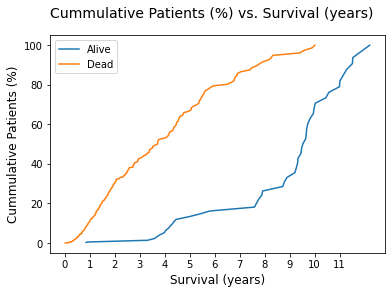

In [52]:
# Plot stuff here

# 1. Plot the cummulative survival for both alive and dead patients
key = 'Survival.time'
ad_data = clinical_data['deadstatus.event']
alive_filter = (ad_data==0)
dead_filter = (ad_data==1)
alive_data = clinical_data[key][alive_filter].sort_values()
dead_data = clinical_data[key][dead_filter].sort_values()

fig = plt.figure()
x_alive_data = pd.Series(alive_data.values).div(365)
y_alive_data = alive_data.cumsum().div(alive_data.sum()/100)
plt.plot(x_alive_data, y_alive_data, label = 'Alive')
x_dead_data = pd.Series(dead_data.values).div(365)
y_dead_data = dead_data.cumsum().div(dead_data.sum()/100)
plt.plot(x_dead_data, y_dead_data, label = 'Dead')
fig.suptitle('Cummulative Patients (%) vs. Survival (years)', fontsize=14)
plt.xlabel('Survival (years)', fontsize=12)
plt.ylabel('Cummulative Patients (%)', fontsize=12)
plt.xticks(np.arange(0, max(x_dead_data)+1, 1.0))
plt.legend()
plt.show()

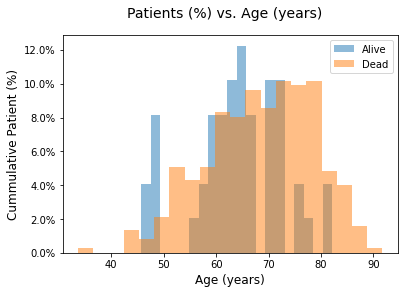

In [53]:
# 2. Plot the distribution of ages
key = 'age'
alive_data = pd.Series(clinical_data[key][alive_filter].sort_values()).values
dead_data = pd.Series(clinical_data[key][dead_filter].sort_values()).values

fig = plt.figure()
nbins = 20
alive_weights=np.ones(len(alive_data)) / len(alive_data)
plt.hist(alive_data, bins=nbins, alpha=0.5, weights=alive_weights, label='Alive')
dead_weights=np.ones(len(dead_data)) / len(dead_data)
plt.hist(dead_data, bins=nbins, alpha=0.5, weights=dead_weights, label='Dead')
fig.suptitle('Patients (%) vs. Age (years)', fontsize=14)
plt.xlabel('Age (years)', fontsize=12)
plt.ylabel('Cummulative Patient (%)', fontsize=12)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.show()

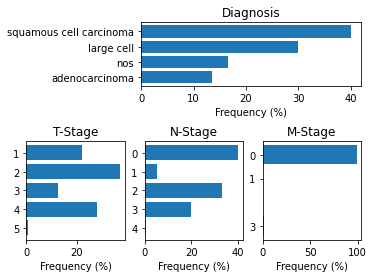

In [54]:
# 3. Plot the frequency of each diagnosis
ax0 = plt.subplot(3,6,(3,6))
y_value = clinical_data['Histology'].value_counts()
y_value = y_value.div(y_value.values.sum()/100)
y_pos = y_value.index
ax0.barh(y_pos, y_value, align='center')
ax0.set_yticks(y_pos)
ax0.invert_yaxis()  # labels read top-to-bottom
ax0.set_xlabel('Frequency (%)')
ax0.set_title('Diagnosis')

ax1 = plt.subplot(234)
y_value = clinical_data['clinical.T.Stage'].value_counts().sort_index()
y_value = y_value.div(y_value.values.sum()/100)
y_pos = y_value.index
ax1.barh(y_pos, y_value, align='center')
ax1.set_yticks(y_pos)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_xlabel('Frequency (%)')
ax1.set_title('T-Stage')

ax2 = plt.subplot(235)
y_value = clinical_data['Clinical.N.Stage'].value_counts().sort_index()
y_value = y_value.div(y_value.values.sum()/100)
y_pos = y_value.index
ax2.barh(y_pos, y_value, align='center')
ax2.set_yticks(y_pos)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.set_xlabel('Frequency (%)')
ax2.set_title('N-Stage')

ax3 = plt.subplot(236)
y_value = clinical_data['Clinical.M.Stage'].value_counts().sort_index()
y_value = y_value.div(y_value.values.sum()/100)
y_pos = y_value.index
ax3.barh(y_pos, y_value, align='center')
ax3.set_yticks(y_pos)
ax3.invert_yaxis()  # labels read top-to-bottom
ax3.set_xlabel('Frequency (%)')
ax3.set_title('M-Stage')

plt.show()

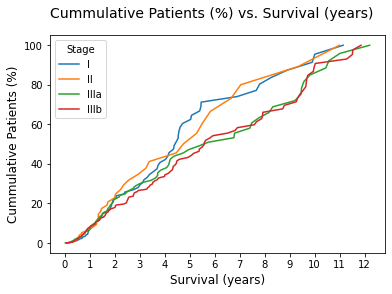

In [55]:
# 4. Plot the cummulative survival for all stages of progression
key = 'Survival.time'
stage_data = clinical_data['Overall.Stage']
# Get the stages
stages = set(stage_data.values)
# Remove `nan` values
stages = {x for x in stages if pd.notna(x)}
# Convert and sort
stages = list(stages)
stages.sort()

# Store the data for each stage in a dictionary
all_data = {}
for s in stages:
    all_data[s] = clinical_data[key][(stage_data==s)].sort_values()

# Plot a line for each stage's data
fig = plt.figure()
for s in stages:
    temp_data = all_data[s]
    x_data = pd.Series(temp_data.values).div(365)
    y_data = temp_data.cumsum().div(temp_data.sum()/100)
    plt.plot(x_data, y_data, label = s)

# Annotate the figure
fig.suptitle('Cummulative Patients (%) vs. Survival (years)', fontsize=14)
plt.xlabel('Survival (years)', fontsize=12)
plt.ylabel('Cummulative Patients (%)', fontsize=12)
plt.xticks(np.arange(0, max(x_data)+1, 1.0))
plt.legend(title='Stage')
plt.show()


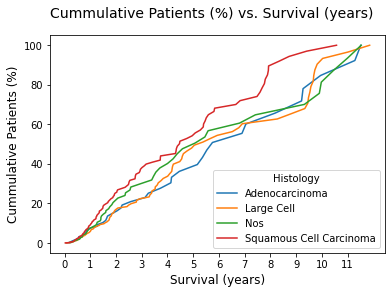

In [56]:
# 5. Plot the cummulative survival for all histologies
key = 'Survival.time'
stage_data = clinical_data['Histology']
# Get the stages
stages = set(stage_data.values)
# Remove `nan` values
stages = {x for x in stages if pd.notna(x)}
# Convert and sort
stages = list(stages)
stages.sort()

# Store the data for each stage in a dictionary
all_data = {}
for s in stages:
    all_data[s] = clinical_data[key][(stage_data==s)].sort_values()

# Plot a line for each stage's data
fig = plt.figure()
for s in stages:
    temp_data = all_data[s]
    x_data = pd.Series(temp_data.values).div(365)
    y_data = temp_data.cumsum().div(temp_data.sum()/100)
    plt.plot(x_data, y_data, label = s.title())

# Annotate the figure
fig.suptitle('Cummulative Patients (%) vs. Survival (years)', fontsize=14)
plt.xlabel('Survival (years)', fontsize=12)
plt.ylabel('Cummulative Patients (%)', fontsize=12)
plt.xticks(np.arange(0, max(x_data)+1, 1.0))
plt.legend(title='Histology')
plt.show()

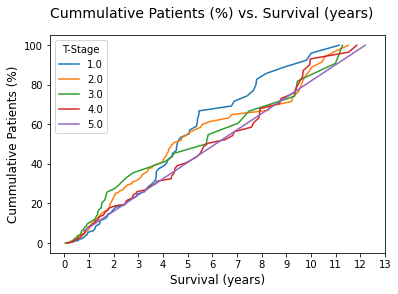

In [57]:
# 6. Plot the cummulative survival based on T-Stage
key = 'Survival.time'
stage_data = clinical_data['clinical.T.Stage']
# Get the stages
stages = set(stage_data.values)
# Remove `nan` values
stages = {x for x in stages if pd.notna(x)}
# Convert and sort
stages = list(stages)
stages.sort()

# Store the data for each stage in a dictionary
all_data = {}
for s in stages:
    all_data[s] = clinical_data[key][(stage_data==s)].sort_values()

# Plot a line for each stage's data
fig = plt.figure()
max_x = 0
for s in stages:
    temp_data = all_data[s]
    x_data = pd.Series(temp_data.values).div(365)
    if max(x_data) > max_x:
        max_x = max(x_data)
    y_data = temp_data.cumsum().div(temp_data.sum()/100)
    if y_data.size == 1:
        plt.plot(x_data, y_data, marker='o', markersize=3, color='orange')
    plt.plot(x_data, y_data, label = str(s).title())

# Annotate the figure
fig.suptitle('Cummulative Patients (%) vs. Survival (years)', fontsize=14)
plt.xlabel('Survival (years)', fontsize=12)
plt.ylabel('Cummulative Patients (%)', fontsize=12)
plt.xticks(np.arange(0, max_x+1, 1.0))
plt.legend(title='T-Stage')
plt.show()

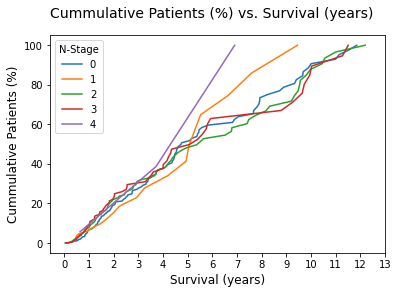

In [58]:
# 7. Plot the cummulative survival based on N-Stage
key = 'Survival.time'
stage_data = clinical_data['Clinical.N.Stage']
# Get the stages
stages = set(stage_data.values)
# Remove `nan` values
stages = {x for x in stages if pd.notna(x)}
# Convert and sort
stages = list(stages)
stages.sort()

# Store the data for each stage in a dictionary
all_data = {}
for s in stages:
    all_data[s] = clinical_data[key][(stage_data==s)].sort_values()

# Plot a line for each stage's data
fig = plt.figure()
max_x = 0
for s in stages:
    temp_data = all_data[s]
    x_data = pd.Series(temp_data.values).div(365)
    if max(x_data) > max_x:
        max_x = max(x_data)
    y_data = temp_data.cumsum().div(temp_data.sum()/100)
    if y_data.size == 1:
        plt.plot(x_data, y_data, marker='o', markersize=3, color='orange')
    plt.plot(x_data, y_data, label = str(s).title())

# Annotate the figure
fig.suptitle('Cummulative Patients (%) vs. Survival (years)', fontsize=14)
plt.xlabel('Survival (years)', fontsize=12)
plt.ylabel('Cummulative Patients (%)', fontsize=12)
plt.xticks(np.arange(0, max_x+1, 1.0))
plt.legend(title='N-Stage')
plt.show()

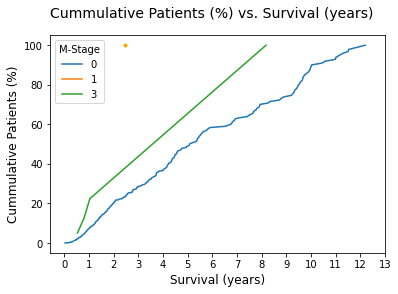

In [59]:
# 8. Plot the cummulative survival based on M-Stage
key = 'Survival.time'
stage_data = clinical_data['Clinical.M.Stage']
# Get the stages
stages = set(stage_data.values)
# Remove `nan` values
stages = {x for x in stages if pd.notna(x)}
# Convert and sort
stages = list(stages)
stages.sort()

# Store the data for each stage in a dictionary
all_data = {}
for s in stages:
    all_data[s] = clinical_data[key][(stage_data==s)].sort_values()

# Plot a line for each stage's data
fig = plt.figure()
max_x = 0
for s in stages:
    temp_data = all_data[s]
    x_data = pd.Series(temp_data.values).div(365)
    if max(x_data) > max_x:
        max_x = max(x_data)
    y_data = temp_data.cumsum().div(temp_data.sum()/100)
    if y_data.size == 1:
        plt.plot(x_data, y_data, marker='o', markersize=3, color='orange')
    plt.plot(x_data, y_data, label = str(s).title())

# Annotate the figure
fig.suptitle('Cummulative Patients (%) vs. Survival (years)', fontsize=14)
plt.xlabel('Survival (years)', fontsize=12)
plt.ylabel('Cummulative Patients (%)', fontsize=12)
plt.xticks(np.arange(0, max_x+1, 1.0))
plt.legend(title='M-Stage')
plt.show()

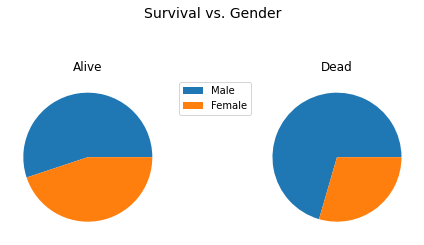

In [60]:
# 9. Plot the distribution of survival based on gender
key = 'gender'
labels = ['Male', 'Female']
x_alive_data = clinical_data[key][alive_filter].value_counts().values
x_dead_data = clinical_data[key][dead_filter].value_counts().values

fig = plt.figure()
plt.subplot(1,2,1)
plt.title('Alive')
plt.pie(x_alive_data, labels=None)
plt.subplot(1,2,2)
plt.title('Dead')
plt.pie(x_dead_data, labels=None)
fig.suptitle('Survival vs. Gender', fontsize=14)
plt.legend(labels, bbox_to_anchor=(0, 1))
plt.tight_layout()
plt.show()

In [62]:
# Read, view, and animate CT files
FOLDER_PATH = os.path.join('LUNG1-001',
                           '09-18-2008-StudyID-69331',
                           '0.000000-82046')
all_dicom = os.listdir(FOLDER_PATH)

fig = plt.figure()
# Get all of the DICOM files in the directory
files = []
for dc in all_dicom:
    FULL_PATH = os.path.join(FOLDER_PATH, dc)
    ds = pydicom.dcmread(FULL_PATH)
    files.append(ds)

# Sort the DICOM into the correct order
slices = sorted(files, key=lambda s: s.SliceLocation)
# Plot the DICOM for each sorted file
images = []
for s in slices:
    images.append([
        plt.imshow(s.pixel_array,
                   cmap=plt.cm.gray,
                   animated=True)
    ])

# Create the animation
im_ani = animation.ArtistAnimation(fig,
                                   images,
                                   interval=50,
                                   repeat_delay=3000,                                                                          blit=True)
# Save as a GIF if desired
im_ani.save('CT_{}.gif'.format(FOLDER_PATH.replace(os.sep,'__')),
            writer='Pillow',
            fps=20)
plt.close()

MovieWriter Pillow unavailable; using Pillow instead.


In [63]:
# Render the animation in the notebook if desired
HTML(im_ani.to_jshtml())

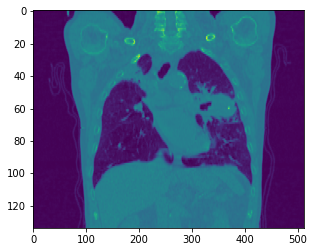

In [109]:
# Determine the ROI of the slices

# Load the DICOM files
files = []
dir_name = FOLDER_PATH
for fname in os.listdir(dir_name):
    files.append(pydicom.dcmread(os.path.join(dir_name,fname)))

# Ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)
slice_location = 65

# Get the pixel aspects, assuming all slices are the same
ps = slices[slice_location].PixelSpacing
ss = slices[slice_location].SliceThickness
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

# Create 3D array
img_shape = list(slices[slice_location].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# Fill 3D array with the images from the files
for i,s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:,:,i] = img2d

# Display stacked slices
ax = plt.subplot()
plt.imshow(np.flipud(img3d[img_shape[0]//2, :, :].T))
ax.set_aspect(cor_aspect)

plt.show()

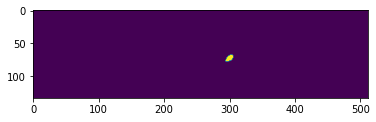

In [85]:
# Visualize the RTStruct
ds = pydicom.dcmread('LUNG1-001/09-18-2008-StudyID-69331/3.000000-78236/1-1.dcm')
ctrs = ds.ROIContourSequence
struct_array = []
for i in range(len(ctrs[0].ContourSequence)):
    struct_array.append(ctrs[0].ContourSequence[i].ContourData)

img = np.zeros((134, 512, 1), 'uint8')
poly = np.array(ctrs[0].ContourSequence[0].ContourData).reshape(-1,3)
rr, cc = skimage.draw.polygon(poly[:,0], 512+poly[:,1], img.shape)
img[rr,cc,0] = 255
plt.imshow(img[:,:,0])
plt.show()

In [110]:
display(slices[65].SliceLocation)
display(poly)

"-486.5"

array([[  75.2 , -218.01, -486.5 ],
       [  77.15, -218.01, -486.5 ],
       [  77.37, -217.84, -486.5 ],
       [  78.06, -215.88, -486.5 ],
       [  77.75, -213.93, -486.5 ],
       [  77.15, -212.74, -486.5 ],
       [  76.75, -211.98, -486.5 ],
       [  76.06, -210.02, -486.5 ],
       [  75.2 , -208.9 , -486.5 ],
       [  74.43, -208.07, -486.5 ],
       [  73.24, -207.15, -486.5 ],
       [  71.29, -206.54, -486.5 ],
       [  69.34, -206.52, -486.5 ],
       [  67.45, -208.07, -486.5 ],
       [  67.44, -210.02, -486.5 ],
       [  68.09, -211.98, -486.5 ],
       [  69.34, -213.7 , -486.5 ],
       [  69.52, -213.93, -486.5 ],
       [  71.29, -215.7 , -486.5 ],
       [  71.5 , -215.88, -486.5 ],
       [  73.24, -217.1 , -486.5 ],
       [  74.87, -217.84, -486.5 ]])

MovieWriter Pillow unavailable; using Pillow instead.


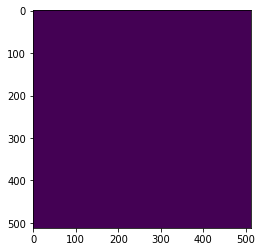

In [126]:
# View the segmentation
ds = pydicom.dcmread('LUNG1-001/09-18-2008-StudyID-69331/300.000000-Segmentation-9.554/1-1.dcm')
pixels = ds.pixel_array

images = []
for s in range(pixels.shape[0]):
    images.append([
        plt.imshow(ds.pixel_array[s,:,:],
                   #cmap=plt.cm.gray,
                   animated=True)
    ])

# Create the animation
fig = plt.figure()
im_ani = animation.ArtistAnimation(fig,
                                   images,
                                   interval=50,
                                   repeat_delay=3000,                                                                          blit=True)
# Save as a GIF if desired
im_ani.save('SEG_{}.gif'.format(FOLDER_PATH.replace(os.sep,'__')),
            writer='Pillow',
            fps=20)
plt.close()
# Render the animation in the notebook if desired
HTML(im_ani.to_jshtml())

In [128]:
ds.pixel_array[0,:,:].shape

(512, 512)